In [546]:
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle
import numpy as np
import cv2

In [557]:
# Load and process test data
test_set = np.load("data/test_imgs.npy",allow_pickle=True)
test_lbl = np.load("data/test_coords.npy",allow_pickle=True)
test_lbl = test_lbl.reshape(test_lbl.shape[0],6)

In [558]:
use_cuda = True
if use_cuda:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [559]:
test_set = torch.tensor(test_set).float()
test_lbl = torch.tensor(test_lbl).float()

In [560]:
# Send data to device
test_set = test_set.to(device)
test_lbl = test_lbl.to(device)

test_set = test_set.float()
test_lbl = test_lbl.float()

In [561]:
test_set.device
test_lbl.device

device(type='cuda', index=0)

In [562]:
# Reconstruct the structure of the neural network
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 3, 5)

        self.fc1 = nn.Linear(507, 16 * 16)
        self.fc2 = nn.Linear(16*16, 8*8)
        self.fc3 = nn.Linear(8*8, 4*4)
        self.fc4 = nn.Linear(4*4, 6)

        self.do = torch.nn.Dropout(p = 0.5)

    def forward(self, x):


        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch

        x = self.do(x)



        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x


net = Net()

In [563]:
# Load weight of each layer into the network
if (use_cuda):
    net.load_state_dict(torch.load('model_checkpoints/single_triangle_4_10.pt'))
else:
    net.load_state_dict(torch.load('model_checkpoints/single_triangle_4_10.pt',map_location = torch.device('cpu')))

In [564]:
#Send neural network to device
net.to(device)

Net(
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=507, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=6, bias=True)
  (do): Dropout(p=0.5, inplace=False)
)

In [565]:
#Get predictions and reshape the matrix
predictions = net(test_set.reshape(100,1,64,64))

predictions = predictions.cpu().detach().numpy().reshape(100,3,2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

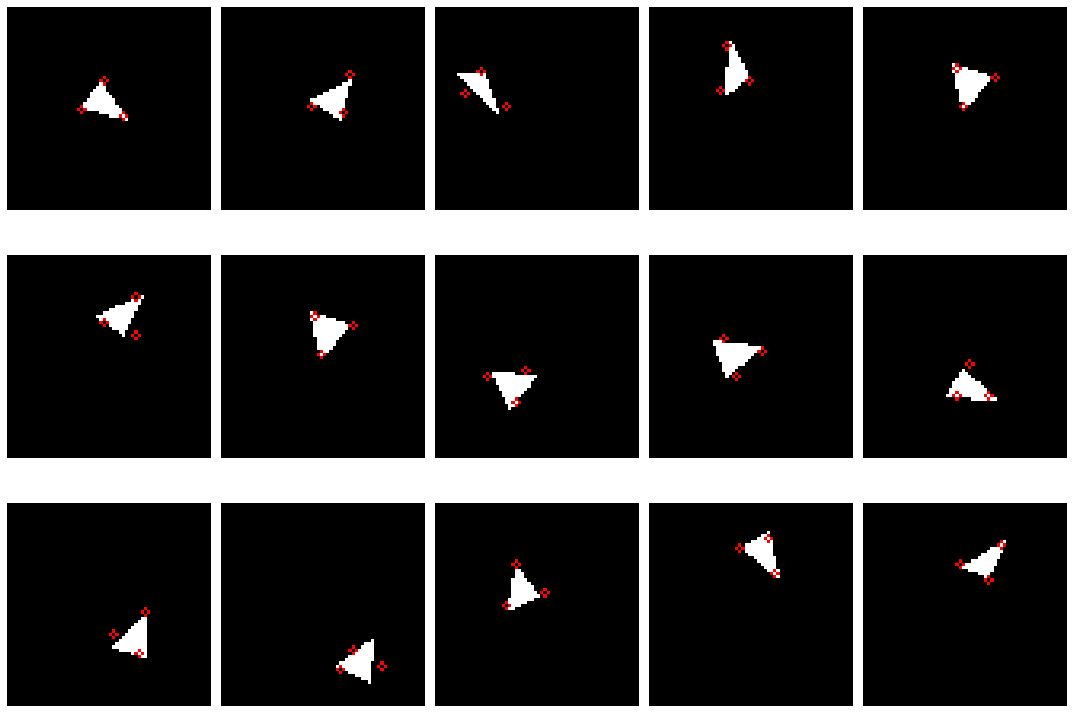

In [567]:
# Randomly pick 15 predictions to display
test_id = np.random.randint(low = 0,high = 100,size = (3,5))

fig, axs = plt.subplots(3, 5, figsize= (15,11))
for row in range(3):
    for col in range(5):
        bg = np.empty([64,64,3])
        bg[:,:,0] = test_set[test_id[row,col]].cpu().numpy() * 255
        bg[:,:,1] = test_set[test_id[row,col]].cpu().numpy()* 255
        bg[:,:,2] = test_set[test_id[row,col]].cpu().numpy() * 255
        for prediction in predictions[test_id[row,col]]:
            image = cv2.circle(bg, (int(prediction[0]),int(prediction[1])) , 1, (255,0,0), 1)
        

        axs[row,col].imshow(image)
        axs[row,col].axis('off')
fig.tight_layout(h_pad=0.5)

plt.show()